# Sensitivity Uncertainty vs. Record Length

This Notebook produces a figure, plotting the SIA Sensitivity to CO<sub>2</sub> or GMST Uncertainty in relation to the end year of the regression period / the record length.

## Import Libraries

In [1]:
# General imports
import numpy as np
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Data handling
import pandas as pd
import xarray as xr

# Custom modules
import functions.helper as hlp
import functions.emulator_func as em

from functions.custom_logger_functions import *

## Set Paths

In [2]:
basepath = "/Users/quraus001/Documents/Uni/Thesis/"
datapath = basepath + "data/"
plotpath = basepath + "Paper/endyear/"

save_plots = False

## Load Data

In [3]:
# observed CO2 data (Global Carbon Project)
df_co2 = pd.read_csv(datapath + "co2/CO2_historical_global-carbon-budget_cum.csv", index_col="Year") 

# sea-ice area (UHH-SIA)
file   = "SIA_observations_nh_v2025_fv0.01_nsidc_osisaf.nc" 
ds_sia = xr.open_dataset(datapath + file)
df_sia = ds_sia.sel(time=ds_sia['time'].dt.month == 9).to_dataframe() # select September data
df_sia.index = df_sia.index.year # convert datetime index to years
df_sia = df_sia.loc[1979:2024] # limit to satellite era
df_sia = df_sia.drop(columns=['nsidc_cdr'])

# GMST data (Berkeley Earth, GISSTEMPv4, NOAA, HadCRUT4)
df_gmst = pd.read_csv(f"{datapath}GMST/GMST_anomaly-1951-1980_GISSTEMPv4-BerkeleyEarth-NOAA-HadCRUT4-Kadow.csv", 
                      comment="#", sep=",", skipinitialspace=True, 
                      names=["Year", "BerkeleyEarth", "GISSTEMPv4", "NOAA", "HadCRUT4", "Kadow", "NOAA_rebased", "HadCRUT4_rebased", "Kadow_rebased"])
df_gmst.set_index("Year", inplace=True)  # convert time index to years
df_gmst

,BerkeleyEarth,GISSTEMPv4,NOAA,HadCRUT4,Kadow,NOAA_rebased,HadCRUT4_rebased,Kadow_rebased
Year,,,,,,,,
1850,NaN,-0.436,-0.496959,-0.417711,-0.460125,-0.220257,-0.341109,-0.375673
1851,NaN,-0.321,-0.390814,-0.233350,-0.439743,-0.114113,-0.156747,-0.355290
1852,NaN,-0.292,-0.352384,-0.229399,-0.337969,-0.075682,-0.152797,-0.253516
1853,NaN,-0.295,-0.407147,-0.270354,-0.394087,-0.130445,-0.193752,-0.309635
1854,NaN,-0.283,-0.367742,-0.291521,-0.403480,-0.091040,-0.214919,-0.319028
...,...,...,...,...,...,...,...,...
2020,1.01,1.049,0.711575,0.922921,0.903198,0.988277,0.999523,0.987651
2021,0.85,0.895,0.559328,0.761906,0.739998,0.836029,0.838508,0.824451
2022,0.89,0.936,0.591291,0.801305,0.793924,0.867992,0.877908,0.878376


## Main Loop

In [6]:
logLevel = "error"
runs = 100000

end_years = np.arange(1995, 2025, 5)
end_years = np.append(end_years, [2024])

params = {"sia_ts": "osisaf",
           "df_forcing": df_co2,
           "df_sia": df_sia,
           "runs": runs,
           "noise_type": "ar1",
           "observation_start": 1979,
           "observation_end": 2024,
           "true_slope": None,
           "amplitude": None,
           "ar1_corrcoef": None,
           "co2_name": "both_cum",
           "sigma_correction": True,
           "phi_correction": True,
           "co2_units": True}

logger = build_terminal_logger(logLevel, "endyear_experiment")

# Storage for results
Means, STD1, STD2 = [], [], []
Means_gmst, STD1_gmst, STD2_gmst = [], [], []

# Products to analyze
products = ["osisaf", "nsidc_bt", "nsidc_nt"]
gmst_products = ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']

# Helper functions to collect statistics
def collect_stats(vals):
    arr = np.asarray(vals, float)
    mu, s1 = arr.mean(), arr.std()
    return float(mu), float(s1), float(2*s1)

def stats_to_array(Means, STD1, STD2):
    Means = np.array(Means)
    STD1  = np.array(STD1)
    STD2  = np.array(STD2)  
    return Means, STD1, STD2

# Main loop over end years
for end_year in tqdm(end_years[:]):
    logger.info(f"\nEnd year: {end_year}")
    logger.debug(f"Record length: {end_year - 1979 +1}")
    params["observation_end"]   = end_year

    SENS = []
    SENS_gmst = []
    #gmst_products = ["BerkeleyEarth", "GISSTEMPv4", "NOAA", "HadCRUT4", "Kadow"]
    for product in products[:]:
        logger.debug(product)
        params["sia_ts"] = product
        Sensitivities, obs_sens, emulator_sia = em.experiment(**params)
        SENS += Sensitivities

        for gmst_product in gmst_products[:]:
            logger.debug(f"  with GMST: {gmst_product}")
            params_gmst = params.copy()
            params_gmst["co2_units"]  = False
            params_gmst["df_forcing"] = df_gmst
            params_gmst["co2_name"]   = gmst_product
            params_gmst["runs"]       = int(runs/len(products))
            Sensitivities_gmst, obs_sens_gmst, emulator_sia_gmst = em.experiment(**params_gmst)
            SENS_gmst += Sensitivities_gmst

    mu, s1, s2 = collect_stats(SENS)
    Means.append(mu); STD1.append(s1); STD2.append(s2)
    logger.debug(f"Sensitivity: {np.mean(SENS):1.2f} ± {np.std(SENS):1.2f} (1σ), ± {2*np.std(SENS):1.2f} (2σ)")

    mu_g, s1_g, s2_g = collect_stats(SENS_gmst)
    Means_gmst.append(mu_g); STD1_gmst.append(s1_g); STD2_gmst.append(s2_g)
    logger.debug(f"GMST Sensitivity: {np.mean(SENS_gmst):1.2f} ± {np.std(SENS_gmst):1.2f} (1σ), ± {2*np.std(SENS_gmst):1.2f} (2σ)")

# Convert to arrays
Means, STD1, STD2  = stats_to_array(Means, STD1, STD2)
Means_gmst, STD1_gmst, STD2_gmst = stats_to_array(Means_gmst, STD1_gmst, STD2_gmst)

100%|██████████| 7/7 [16:55<00:00, 145.13s/it]


## Plotting

In [7]:
print(Means)
print(end_years)
print(STD2)

for i in range(len(end_years)):
    print(f"{end_years[i]}, {Means[i]:1.2f}, {STD2[i]:1.2f} ")

[-2.17515732 -2.00618518 -2.15200696 -2.69104192 -2.66745609 -2.49635092
 -2.24727187]
[1995 2000 2005 2010 2015 2020 2024]
[1.47605979 0.9511557  0.63620594 0.65230563 0.59336586 0.5034018
 0.48504153]
1995, -2.18, 1.48 
2000, -2.01, 0.95 
2005, -2.15, 0.64 
2010, -2.69, 0.65 
2015, -2.67, 0.59 
2020, -2.50, 0.50 
2024, -2.25, 0.49 


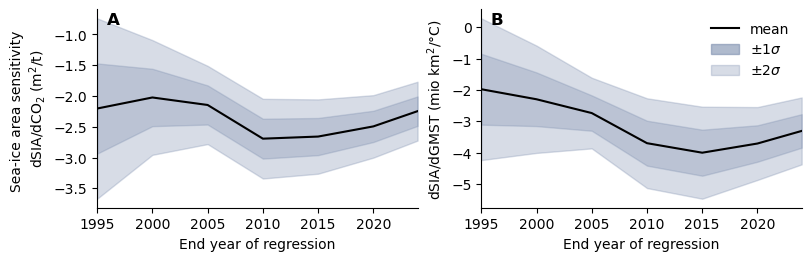

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,2.5), constrained_layout=True)

ax1.plot(end_years, Means, color="black")
ax2.plot(end_years, Means_gmst, color="black")

color = "#7B8CAD" # "#00577d"
ax1.fill_between(end_years, Means - STD1, Means + STD1, alpha=0.3, color=color) ## "#00577d" "#7B8CAD"
ax2.fill_between(end_years, Means_gmst - STD1_gmst, Means_gmst + STD1_gmst, alpha=0.3, color=color)

ax1.fill_between(end_years, Means - STD2, Means + STD2, alpha=0.3, color=color)
ax2.fill_between(end_years, Means_gmst - STD2_gmst, Means_gmst + STD2_gmst, alpha=0.3, color=color)

for ax, letter in zip([ax1, ax2], ["A", "B"]):
    ax.margins(x=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("End year of regression")
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12)

ax1.set_ylabel("Sea-ice area sensitivity \ndSIA/dCO$_2$ (m$^2$/t)")
ax2.set_ylabel("dSIA/dGMST (mio km$^2$/°C)")

legend_elements = [Line2D([np.nan],[np.nan],color = "black", label = "mean", alpha=1),
                        Patch(color = color, label = r"$\pm1\sigma$", alpha=0.6),
                    Patch(color = color, label = r"$\pm2\sigma$", alpha=0.3)]

lgd = ax.legend(loc='upper right',handles = legend_elements, frameon=False)

#fig.subplots_adjust(wspace=0.2)
filename = "endyear_all_sub-obs_co2-gmst"
#hlp.save_plot(plotpath + filename, save_plots, ["png","pdf"], dpi=300)